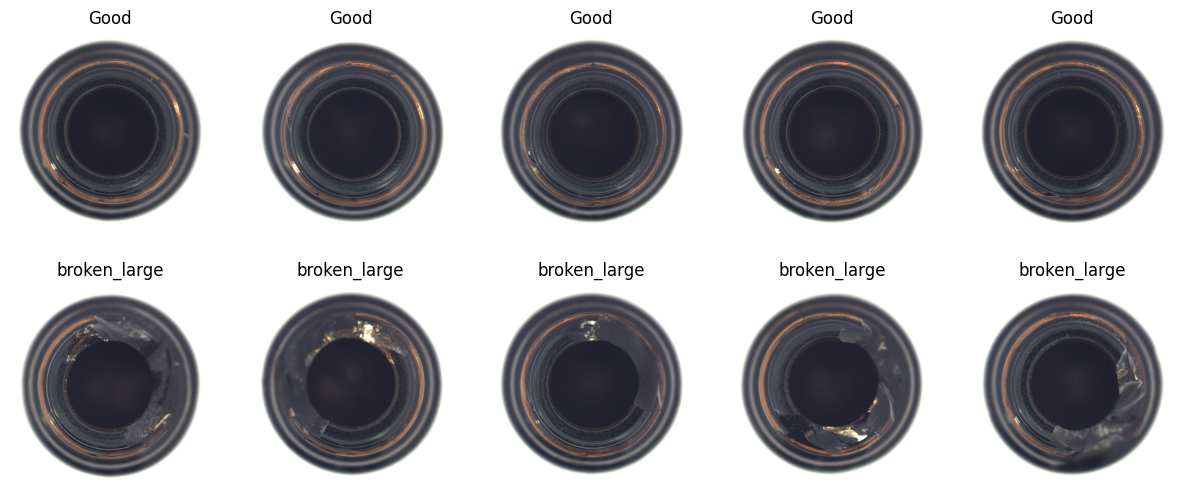

In [6]:
import os
import matplotlib.pyplot as plt
import random

def display_good_and_anomalous_images(base_path, anomaly_type, num_images=5):
    """
    Displays a mix of 'good' and 'anomalous' images from the specified MVTec category.
    
    Parameters:
    - base_path (str): Base path to the MVTec dataset.
    - category (str): The category (e.g., "bottle", "capsule") to display images from.
    - anomaly_type (str): The specific type of anomaly (e.g., "broken_large", "contamination").
    - num_images (int): Number of images to display for each type (good and anomalous).
    """
    # Paths to good and anomalous images
    good_path = os.path.join(base_path, "train", "good")
    anomaly_path = os.path.join(base_path, "test", anomaly_type)

    # List all images in the directories
    good_images = os.listdir(good_path)
    anomaly_images = os.listdir(anomaly_path)

    # Randomly select images to display
    selected_good_images = random.sample(good_images, min(num_images, len(good_images)))
    selected_anomaly_images = random.sample(anomaly_images, min(num_images, len(anomaly_images)))

    # Plot the images
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
    
    # Display good images
    for i, img_name in enumerate(selected_good_images):
        img_path = os.path.join(good_path, img_name)
        img = plt.imread(img_path)
        axes[0, i].imshow(img)
        axes[0, i].axis("off")
        axes[0, i].set_title("Good")

    # Display anomalous images
    for i, img_name in enumerate(selected_anomaly_images):
        img_path = os.path.join(anomaly_path, img_name)
        img = plt.imread(img_path)
        axes[1, i].imshow(img)
        axes[1, i].axis("off")
        axes[1, i].set_title(anomaly_type)

    plt.show()

# Example usage
# Set the base path to the MVTec dataset location on your computer
base_path = "bottle/bottle" # cooked path
display_good_and_anomalous_images(base_path,  anomaly_type="broken_large", num_images=5)


In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


In [9]:
class VAE(nn.Module):
    def __init__(self, input_dim=64*64, hidden_dim=512, latent_dim=128):
        super(VAE, self).__init__()
        # Encoder layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)
        # Decoder layers
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc2_mu(h), self.fc2_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def loss_function(self, recon_x, x, mu, logvar):
        # Reconstruction loss
        BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction="sum")
        # KL divergence loss
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + KLD


In [11]:
class MVTecDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder)]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        img = Image.open(img_path).convert("L")  # Convert to grayscale
        if self.transform:
            img = self.transform(img)
        return img.view(-1)  # Flatten the image


In [18]:
# Path to 'good' training images for bottle category
train_data_path = "bottle/bottle/train/good"
test_data_path_broken = "bottle/bottle/test/broken_large"
test_data_path_good = "bottle/bottle/test/good"

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

train_dataset = MVTecDataset(train_data_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [13]:
# Model, optimizer, and device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    vae.train()
    train_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(batch)
        loss = vae.loss_function(recon_batch, batch, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset):.4f}")


Epoch 1, Loss: 2363.8296
Epoch 2, Loss: 1673.6817
Epoch 3, Loss: 1568.5237
Epoch 4, Loss: 1548.5722
Epoch 5, Loss: 1539.9395
Epoch 6, Loss: 1533.0412
Epoch 7, Loss: 1526.6231
Epoch 8, Loss: 1525.0995
Epoch 9, Loss: 1523.7833
Epoch 10, Loss: 1518.9275
Epoch 11, Loss: 1517.8891
Epoch 12, Loss: 1517.6789
Epoch 13, Loss: 1517.1694
Epoch 14, Loss: 1517.2297
Epoch 15, Loss: 1515.7964
Epoch 16, Loss: 1515.4931
Epoch 17, Loss: 1511.9231
Epoch 18, Loss: 1511.9531
Epoch 19, Loss: 1510.6444
Epoch 20, Loss: 1510.5833


In [20]:
# kinda random threshold, looked at the values and saw that 10 would work well
def anomaly_score(vae, image, threshold=10):
    vae.eval()
    with torch.no_grad():
        recon_image, _, _ = vae(image.to(device))
        loss = nn.functional.mse_loss(recon_image, image.to(device), reduction="sum").item()
    return loss > threshold, loss

# Load a batch of test images
test_dataset = MVTecDataset(test_data_path_broken, transform=transform)
test_dataset1 = MVTecDataset(test_data_path_good, transform=transform)
test_loader_broken = DataLoader(test_dataset, batch_size=1, shuffle=True)
test_loader_good = DataLoader(test_dataset1, batch_size=1, shuffle=True)

# Check anomaly score for each test image
def check_anomaly(loader):    
    for i, image in enumerate(loader):
        is_anomaly, score = anomaly_score(vae, image)
        print(f"Image {i+1}, Anomaly: {is_anomaly}, Score: {score}")
        if i == 9:  # Display 10 samples for brevity
            break
check_anomaly(test_loader_broken)
check_anomaly(test_loader_good)

Image 1, Anomaly: True, Score: 14.858856201171875
Image 2, Anomaly: False, Score: 9.033140182495117
Image 3, Anomaly: True, Score: 14.924997329711914
Image 4, Anomaly: True, Score: 14.58298110961914
Image 5, Anomaly: False, Score: 8.86050796508789
Image 6, Anomaly: True, Score: 16.653156280517578
Image 7, Anomaly: True, Score: 11.402937889099121
Image 8, Anomaly: False, Score: 6.507359981536865
Image 9, Anomaly: True, Score: 12.148115158081055
Image 10, Anomaly: True, Score: 14.280494689941406
Image 1, Anomaly: False, Score: 9.724283218383789
Image 2, Anomaly: False, Score: 5.9677348136901855
Image 3, Anomaly: False, Score: 3.132436752319336
Image 4, Anomaly: False, Score: 4.084146499633789
Image 5, Anomaly: False, Score: 8.526887893676758
Image 6, Anomaly: False, Score: 9.41724967956543
Image 7, Anomaly: True, Score: 12.583974838256836
Image 8, Anomaly: False, Score: 6.299918174743652
Image 9, Anomaly: True, Score: 10.987691879272461
Image 10, Anomaly: False, Score: 6.714682579040527


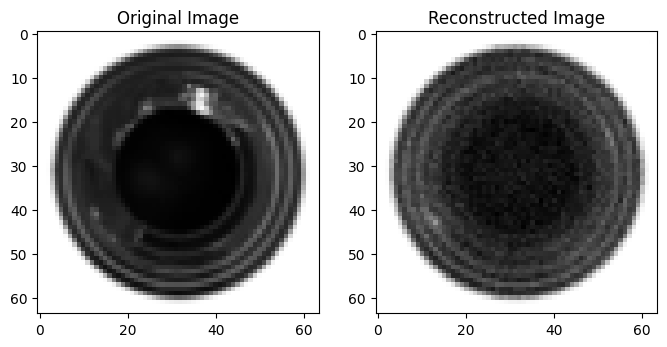

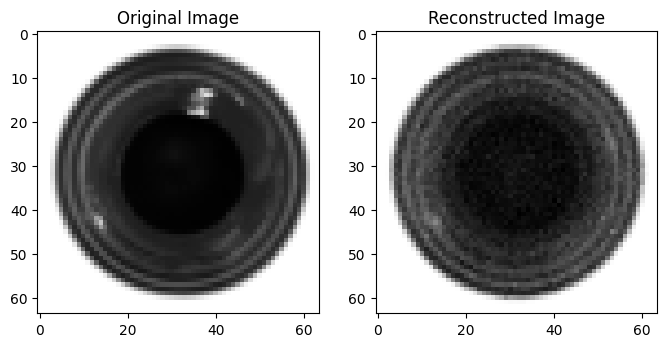

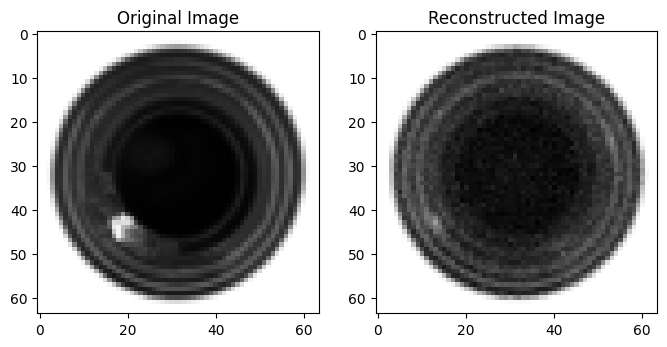

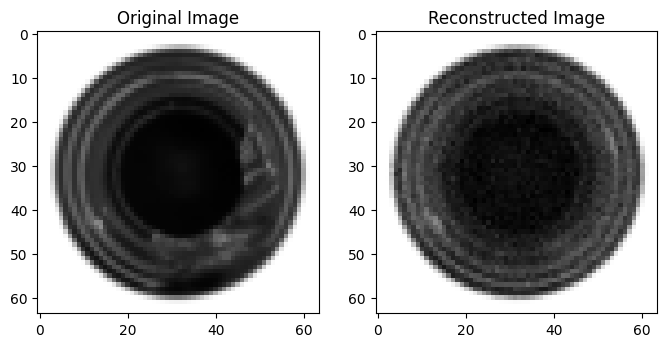

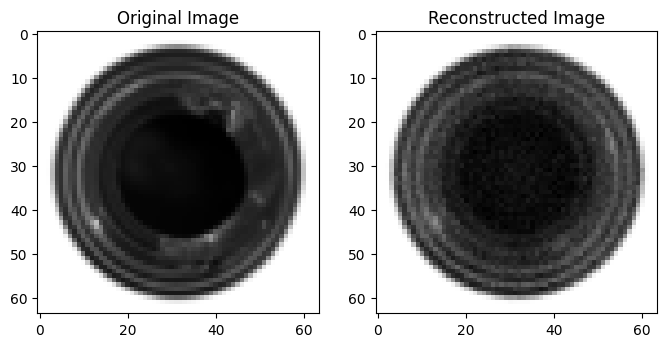

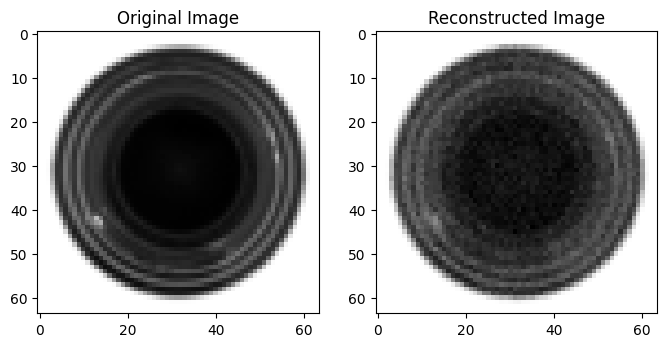

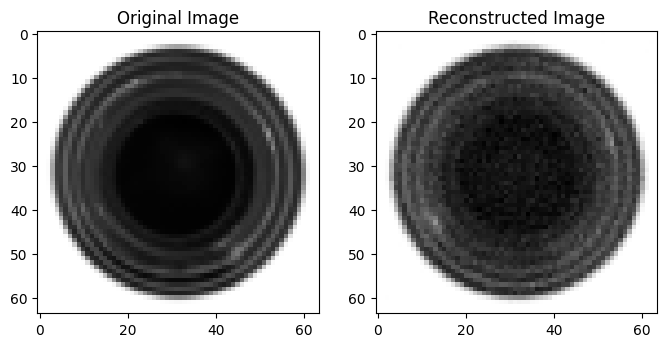

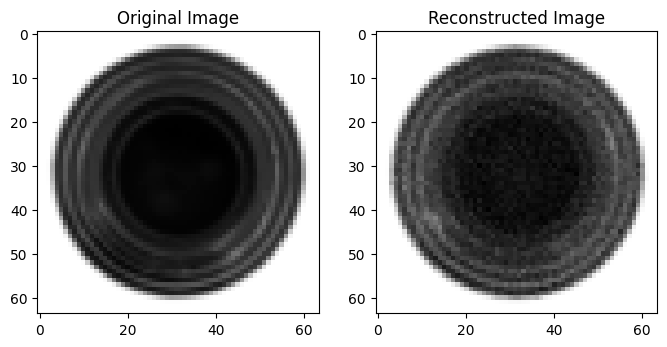

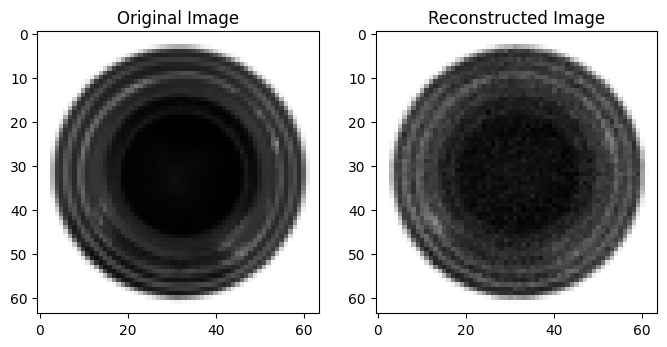

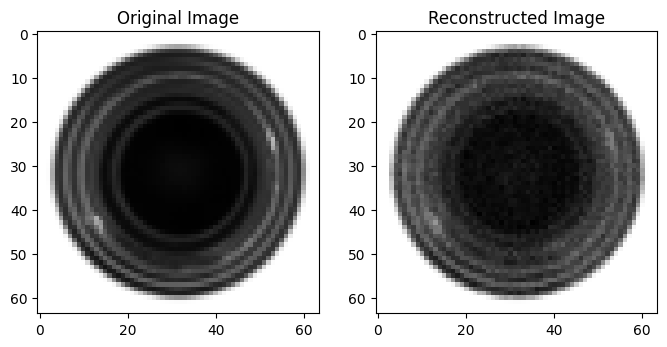

In [21]:
# Display original and reconstructed images
def print_images(loader):    
    for i, image in enumerate(loader):
        if i == 5:  # Display only 5 samples
            break
        image = image.to(device)
        recon_image, _, _ = vae(image)
        
        # Convert images to CPU for visualization
        image = image.view(64, 64).cpu().numpy()
        recon_image = recon_image.view(64, 64).cpu().detach().numpy()
        
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        axes[0].imshow(image, cmap="gray")
        axes[0].set_title("Original Image")
        axes[1].imshow(recon_image, cmap="gray")
        axes[1].set_title("Reconstructed Image")
        plt.show()

print_images(test_loader_broken)
print_images(test_loader_good)